# Исследование потенциально популярных игр на различные платформы

Мы устроились в интернет-магазин «Стримчик», который продаёт по всему миру компьютерные игры. 
<br>Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).
<br>Нам требуется установаить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. 
<br>
<br>У нас имеются данные с 1985 по 2016 гг, которые следует обработать прежде, чем начать анализ, с помощью котрого мы сможем понять какие платформы и жанры интересны среднестатистическому потребителю из разных стран.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

### Открываем файл

In [2]:
# Открываем файл и смотрим
try:
    data = pd.read_csv('/datasets/games.csv')
except:
    data = pd.read_csv('games.csv')
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
# смотрим на общий вид
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


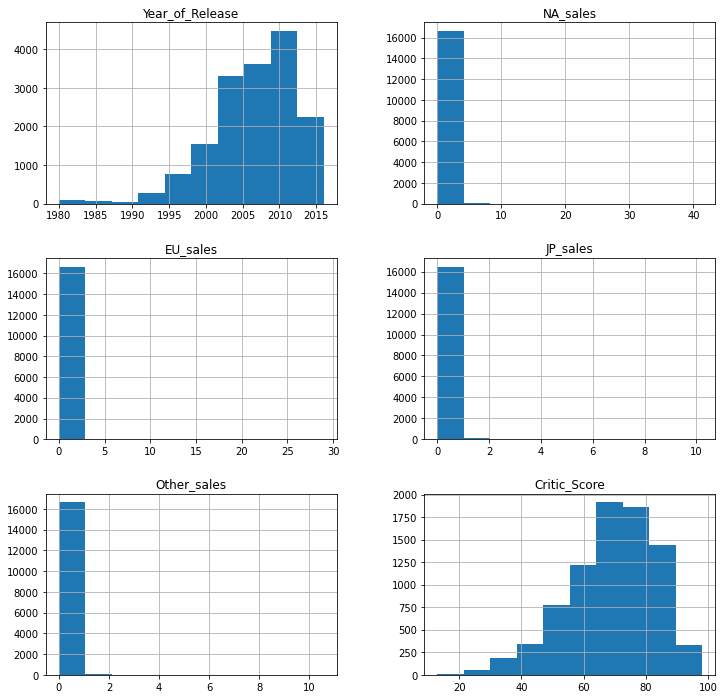

In [4]:
# посторим графики
data.hist(figsize=(12,12));

**Предварительно посмотрев на данные можно увидеть, что в основном пропуски в данных это различного рода рейтинги**
<br>**Есть не соответсвие типов данных + можно часть понизить**
<br>**Так же основная масса игр распространяется до 100м копий не зависимо от стран**
<br>**Игровая индустрия процветает до 2010 года, потом что-то пошло не так, надо разобраться**
<br>**Оценки критиков в районе 70**

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Хорошо, изучили данные для предобработки.</font>

### Подготовка данных

#### Приведем к нижнему регистру столбцы

In [5]:
# понизим в нижний регистр
data = data.rename(str.lower, axis='columns')

#### **Поиск пропущенных значений и их обработка**

In [6]:
# смотрим на количество пропусков
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

**Пропуски в признаках:**
<br>1) name - названия игр
<br>2) year_of_release - год релиза 
<br>3) genre - жанр
<br>4) critic_score - оценка критиков
<br>5) user_score - оценка пользователей
<br>6) rating - возрастной рейтинг

In [7]:
# удаляем пропуски без названий
data = data.dropna(subset=['name'])

In [8]:
# смотрим на подозрительно похожие два пропуска в жанре
data['genre'].isna().sum()

0

**Удалив игры без названий, пропуски в жанре тоже пропали**

In [9]:
# посмотрим на отношение пропусков даты релиза ко всему набору данных
print(f"Количество процентов потери данных при удалении: {data['year_of_release'].isna().sum()  / data.shape[0] * 100:.2}%")

Количество процентов потери данных при удалении: 1.6%


**Количество пропущенных дат релизов, не превышает 5% от общего набора данных, можно с ним попрощаться**

In [10]:
# удаляем объекты с пропусками в дате релиза
data = data.dropna(subset=['year_of_release'])

In [11]:
# посмотрим на рейтинги критиков
data['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

**С рейтингами критиков ничего не поделаешь, выбивающихся значений тоже не наблюдается**

In [12]:
# посмотрим на рейтинги пользователей
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

**В рейтингах пользоватей есть значение "tbd", оно же не определен, заменим на NaN**

In [13]:
# заменим tbd на NaN
data['user_score'] = data['user_score'].replace('tbd', np.nan)

In [14]:
# посмотрим на возрастные рейтинги
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

**Для возрастного рейтинга тоже изменений не предполагаем**

**Между строк посмотрим на дубликаты**

In [15]:
# проверим дубликаты
print('Количетво явных дубликатов:', data.duplicated().sum())

Количетво явных дубликатов: 0


**Таковых не имеется**

#### Изменим типы данных для признаков

In [16]:
# рассмотрим данные
data.info()
d_memory = data.memory_usage().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   object 
 10  rating           9768 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


In [17]:
# немного понизим разряд
data = data.astype({'year_of_release':'uint16', 
                    'na_sales':'float32', 
                    'eu_sales':'float32', 
                    'jp_sales':'float32', 
                    'other_sales':'float32',
                    'user_score' : 'float32',
                    'critic_score' : 'float32'
                    }, errors='ignore') 

new_d_memory = data.memory_usage().sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  uint16 
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float32
 5   eu_sales         16444 non-null  float32
 6   jp_sales         16444 non-null  float32
 7   other_sales      16444 non-null  float32
 8   critic_score     7983 non-null   float32
 9   user_score       7463 non-null   float32
 10  rating           9768 non-null   object 
dtypes: float32(6), object(4), uint16(1)
memory usage: 1.0+ MB


In [18]:
# немного радости
print(f'Сократили объем используемой памяти на {round(new_d_memory / d_memory  * 100,1)}%')

Сократили объем используемой памяти на 68.8%


**Помимо понижения разряда, также изменил тип данных у user_score, потому что он был object, а стал числовым**

#### Подсчет суммарных продаж

In [19]:
# создадим колонку суммарных продаж по миру
data['total_sales'] = data.loc[:,'na_sales':'other_sales'].sum(axis=1)

In [20]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.360001,28.959999,3.77,8.45,76.0,8.0,E,82.539993
1,Super Mario Bros.,NES,1985,Platform,29.080000,3.580000,6.81,0.77,NaN,NaN,NaN,40.240002
2,Mario Kart Wii,Wii,2008,Racing,15.680000,12.760000,3.79,3.29,82.0,8.3,E,35.520000
3,Wii Sports Resort,Wii,2009,Sports,15.610000,10.930000,3.28,2.95,80.0,8.0,E,32.770000
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.270000,8.890000,10.22,1.00,NaN,NaN,NaN,31.380001


</font><font color='Blue'><b>Комментарий студента</b></font><br>
<font color='DarkBlue'><b>Добавил объяснение</b></font>

**Рассмотрев данные выполнил следующие действия с фичами:
<br>Пропуски в колонке name удалил, потому что их всего 2 шт., после этого в колонке жанр пропуски так же удалились(их тоже было 2)
<br>Пропуски в годе релиза так же удалил, поскольку их было не много. Хоть там и были одноименные игры, только на разные платформы, но мы знаем, что релизи на разные платформы могут выходить в разные года
<br>Пропуски в рейтингах оставил не тронутыми, потому что для заполнения данных полей нет какой-то закономерности, единственное после подсказки, возрастной рейтинг надо будет изменить.
<br>Пропуски в данных могут возникнуть по разнным причинам, будь то в окрытом источнике был сбой данных или же игру удалили, как мне кажется это произошло с двумя играми, которые просто есть, но ни заголовка, ни жанра.
<br>Год релиза могли по случайности не указать
<br>Рейтинги вообще отдельная тема, старые игры в принципе шли без рейтингов, соответсвенно там есть пропуски, так же есть подозрение, что если игра была не очень популярной, система не позволяла выставлять рейтинг с малым количесвом выставленных оценок(прим. Если игре поставили оценку всего 20-40 человек, то такой рейтинг попросту не выставлялся)**

In [21]:
# Комментарий ревьюера
# Посмотрим, что у нас осталось
temp = data.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  uint16 
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float32
 5   eu_sales         16444 non-null  float32
 6   jp_sales         16444 non-null  float32
 7   other_sales      16444 non-null  float32
 8   critic_score     7983 non-null   float32
 9   user_score       7463 non-null   float32
 10  rating           9768 non-null   object 
 11  total_sales      16444 non-null  float32
dtypes: float32(7), object(4), uint16(1)
memory usage: 1.1+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio' 'uDraw Studio: Instant Artist'
 '¡Shin Chan Flipa en colores!']


### Начинаем исследовательский анализ

#### Количество игр в разные годы

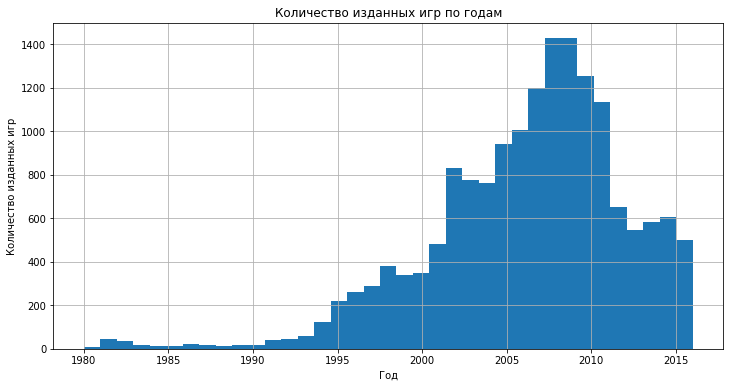

In [22]:
# рассмотрим игры по дате релиза
data['year_of_release'].hist(figsize=(12,6), bins=37)
plt.xlabel('Год')
plt.ylabel('Количество изданных игр')
plt.title('Количество изданных игр по годам');

**Посмотрев на график можно заметить, что активный рост производства игр начинается с 91 года. Ориетнировочно с тех же времен у обычных пользователей все больше стало возможности играть в плане консолей/PC. 
<br>Так же есть спад с 2012 до 2016. Не силен в игровой индустрии, но возможно это желание производителей одно время создавать мобильные игры, которые потом заморозят, что бы на свет появился Diablo Immortal.
<br>В целом не все данные можно использовать, можно ограничить с 1995 года, там был заметный рост**



####  Продажи по платформам

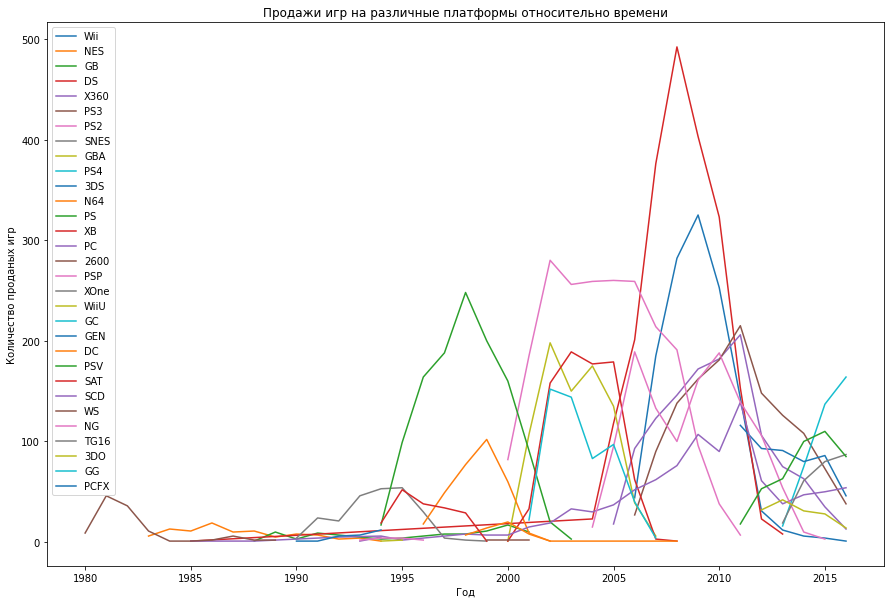

In [25]:
# посмотрим на каких платформах сколько игр продано
data_group_platform = data.groupby(['platform','year_of_release'])['total_sales'].count()
uniques_platform = data['platform'].unique()

for i in uniques_platform:
    data_group_platform[i].plot(figsize=(15,10), legend=True, xlabel='Год', ylabel='Количество проданых игр',label=i)
plt.title('Продажи игр на различные платформы относительно времени');

**Можно увидеть (хотя и не очень показательный график с большим количеством линий), что среднее время жизни платформы 10 лет**

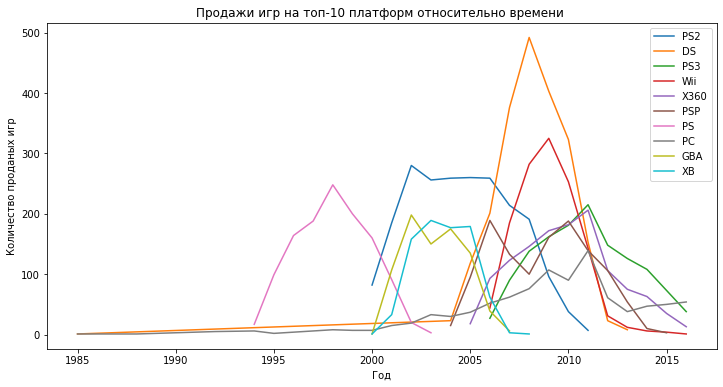

In [26]:
# посмотрим на топ-10 платформ
array_top = np.array(data.groupby(['platform'])['total_sales'].count().sort_values(ascending=False)[:10].index)

for i in array_top:
    data_group_platform[i].plot(figsize=(12,6), legend=True, xlabel='Год', ylabel='Количество проданых игр',label=i)
plt.title('Продажи игр на топ-10 платформ относительно времени ');

**А тут топ-10 по продажам игр на платформы. Бессмертным участником является PC. Ну и можно если присмотреться к таким ребятам как xbox и ps, то можно заметить что платформы они свои обновляют примерно раз в 5 лет**

In [27]:
# выделим топовые платформы по продажам игр
data.groupby(['platform'])['total_sales'].count().sort_values(ascending=False)[:10]

platform
PS2     2127
DS      2121
PS3     1306
Wii     1286
X360    1232
PSP     1193
PS      1190
PC       957
GBA      811
XB       803
Name: total_sales, dtype: int64

**По графикам и цифрам выше, видно, основные платформы это PlayStation, XBox и Nintendo (не зависимо от версии консоли)
<br>Но стоит так же отметить, что при падении игровой индустрии в 2012 году, токо игры на PC стали идти вверх. Но на этом графике не отображабтся последнии версии консолей, потому что продажи на них еще не выросли**

In [28]:
# массив потенциально прибыльных платформ
promising_platforms = np.array(['PC', 'WiiU', 'PS4', 'XOne'])

In [29]:
# ограничим выборку, только перспективными платформами и уберем редкие случаи
data_promising_platforms = data[(data['platform'].isin(promising_platforms)) & (data['total_sales'] < 2)]

In [30]:
# возьмем данные актуального периода (как мы выяснили, не более 5 лет), переписывать твой аргумент думаю глупо =)
actual_data = data.query('year_of_release >= 2012')

In [31]:
# Комментарий ревьюера
data_promising_platforms.year_of_release.min()

1985

**Построим график с усами**

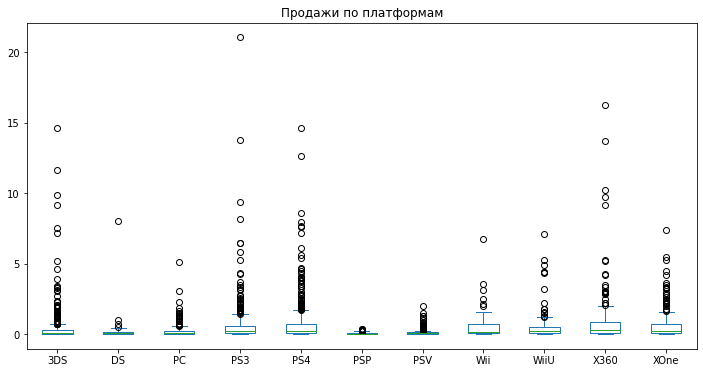

In [32]:
# строим ящик с усами в полном объеме
actual_data.pivot_table(index = 'name', 
                                     columns = 'platform', 
                                     values = 'total_sales', 
                                     aggfunc = 'sum').plot(kind='box', figsize=(12,6), title='Продажи по платформам');

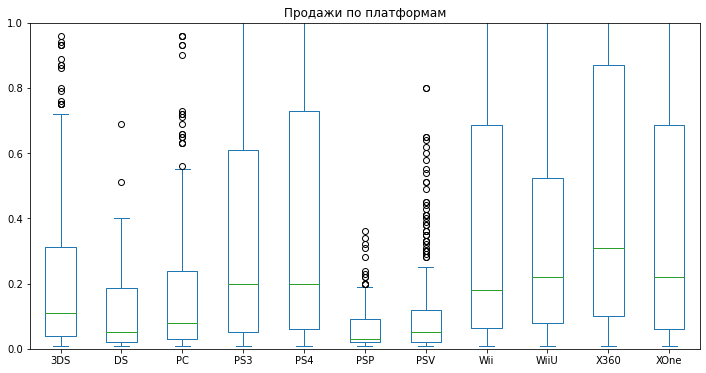

In [33]:
# соберем табличку и построим график с усами масштабированный
actual_data.pivot_table(index = 'name', 
                                     columns = 'platform', 
                                     values = 'total_sales', 
                                     aggfunc = 'sum').plot(kind='box', figsize=(12,6), ylim=(0,1), title='Продажи по платформам');

**На графике мы видим, что больше всего продаж из новых платформ у XBox. У WiiU примерно такие же показатели, но платформа "на закате своей карьеры". Далее идет PlayStation
<br>Многие платформы на закате своей карьеры, поэтому продажи на них не большие
<br>Компьюторы уходят на второй план из-за улучшения качества картинки, хочешь красиво, покупай дорогой компьютор, нежели купить консоль под которую игры оптимизируются(или нет)
<br>Так же на первом графике у PS, Xbox и Nintendo можно заметить точечные выбросы, что говорит о том, что есть на этих платформах "стреляющие" игры**


#### **Посмотрим влиянение критиков и пользователей на продажи. Для начала платформу с "ЭКСКЛЮЗИВАМИ".**

In [34]:
# посмотрим на корреляцию для PS4 (пользователи/продажи)
ps4_data = actual_data[actual_data['platform']=='PS4']
print(f"Корреляция оценок пользователей и общих продаж: {ps4_data['user_score'].corr(ps4_data['total_sales'])}")

Корреляция оценок пользователей и общих продаж: -0.03195710560396696


In [35]:
# Комментарий ревьюера 2
actual_data.year_of_release.min()

2012

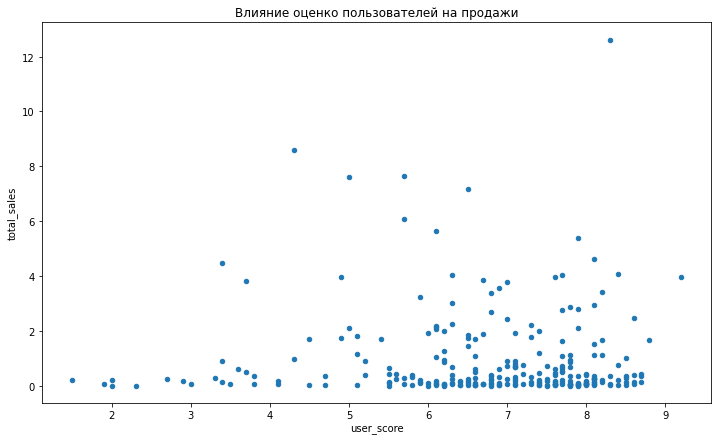

In [36]:
#Построим диаграмму рассеяния
ps4_data.plot(x='user_score', y='total_sales', kind='scatter', figsize=(12,7))
plt.title('Влияние оценко пользователей на продажи');

In [37]:
# посмотрим на корреляцию для PS4 (критики/продажи)
print(f"Корреляция оценок критиков и общих продаж: {ps4_data['critic_score'].corr(ps4_data['total_sales'])}")

Корреляция оценок критиков и общих продаж: 0.4065679010283494


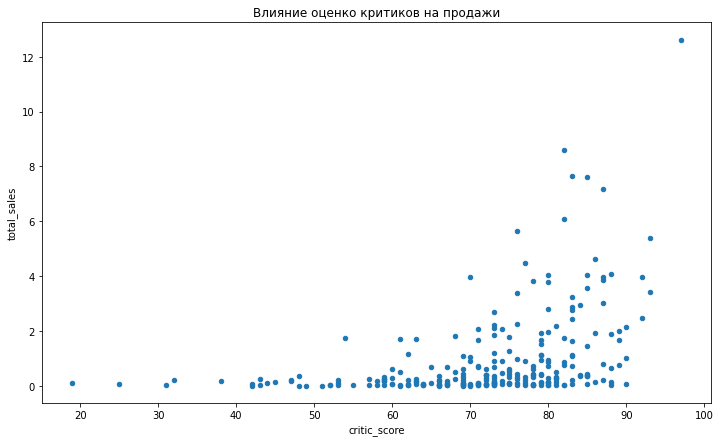

In [38]:
#Построим диаграмму рассеяния
ps4_data.plot(x='critic_score', y='total_sales', kind='scatter', figsize=(12,7))
plt.title('Влияние оценко критиков на продажи');

**На графиках видно, что оценки критиков имеют больший вес на продажи, поскольку если рассмотреть график с оценками критиков, можно заметить смещение вправо, нежели оценки пользователей, которые если бы было больше данных, то заполнение было бы равномерным
<br>Корреляция тоже говорит о том, что хоть и не сильная, но имеется у оценок критиков на продажи, в отличие от оценок пользователей**


**Рассмотрим для других платформ наши наблюдения**

**XBoxOne**

In [39]:
# посмотрим на корреляцию для Xbox (пользователи/продажи) и (критики/продажи)
xbox_data = actual_data[actual_data['platform']=='XOne']
print(f"Корреляция оценок пользователей и общих продаж: {xbox_data['user_score'].corr(xbox_data['total_sales'])}")
print(f"Корреляция оценок критиков и общих продаж: {xbox_data['critic_score'].corr(xbox_data['total_sales'])}")

Корреляция оценок пользователей и общих продаж: -0.06892505829722285
Корреляция оценок критиков и общих продаж: 0.41699832684400107


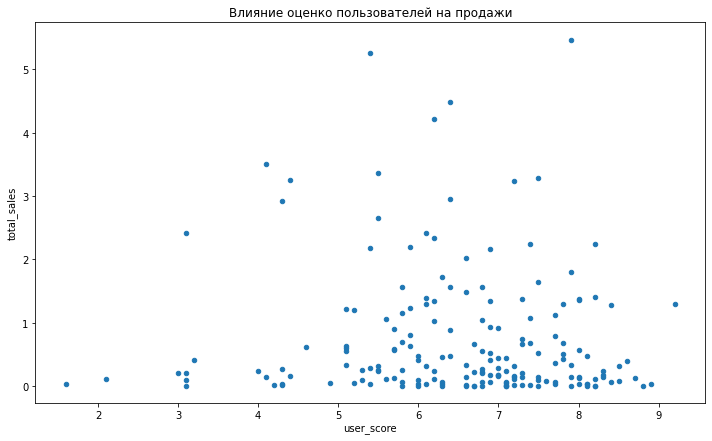

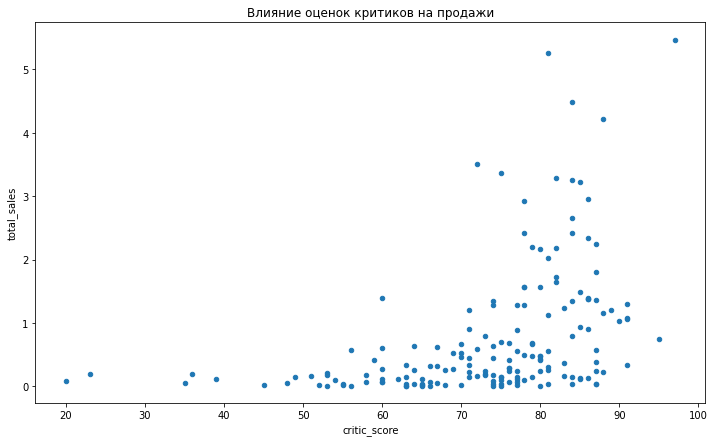

In [40]:
#Построим диаграмму рассеяния
xbox_data.plot(x='user_score', y='total_sales', kind='scatter', figsize=(12,7))
plt.title('Влияние оценко пользователей на продажи');
xbox_data.plot(x='critic_score', y='total_sales', kind='scatter', figsize=(12,7))
plt.title('Влияние оценок критиков на продажи');

**WiiU**

In [41]:
# посмотрим на корреляцию для WiiU (пользователи/продажи) и (критики/продажи)
wiiu_data = actual_data[actual_data['platform']=='WiiU']
print(f"Корреляция оценок пользователей и общих продаж: {wiiu_data['user_score'].corr(wiiu_data['total_sales'])}")
print(f"Корреляция оценок критиков и общих продаж: {wiiu_data['critic_score'].corr(wiiu_data['total_sales'])}")

Корреляция оценок пользователей и общих продаж: 0.4002190371566136
Корреляция оценок критиков и общих продаж: 0.3483797599500602


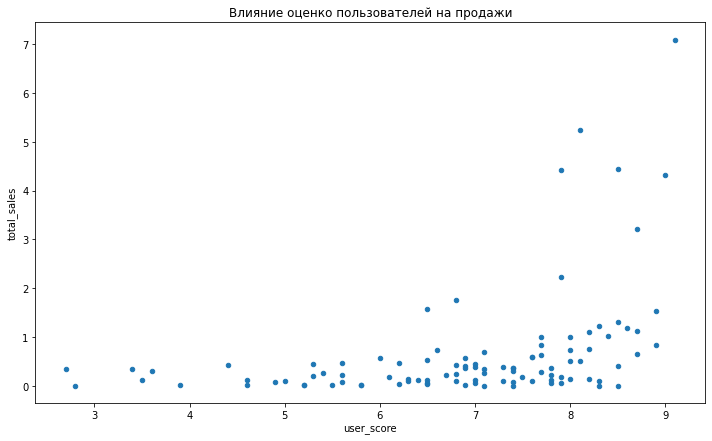

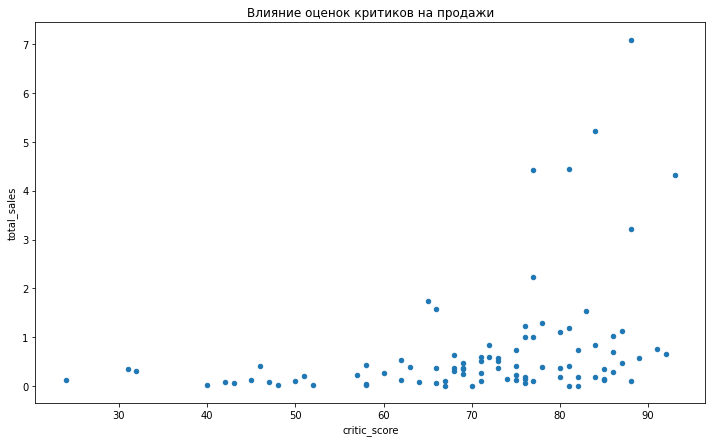

In [42]:
#Построим диаграмму рассеяния
wiiu_data.plot(x='user_score', y='total_sales', kind='scatter', figsize=(12,7))
plt.title('Влияние оценко пользователей на продажи');
wiiu_data.plot(x='critic_score', y='total_sales', kind='scatter', figsize=(12,7))
plt.title('Влияние оценок критиков на продажи');

**PC**

In [43]:
# посмотрим на корреляцию для PC (пользователи/продажи) и (критики/продажи)
pc_data = actual_data[actual_data['platform']=='PC']
print(f"Корреляция оценок пользователей и общих продаж: {pc_data['user_score'].corr(pc_data['total_sales'])}")
print(f"Корреляция оценок критиков и общих продаж: {pc_data['critic_score'].corr(pc_data['total_sales'])}")

Корреляция оценок пользователей и общих продаж: -0.12186748143927072
Корреляция оценок критиков и общих продаж: 0.23724323875744277


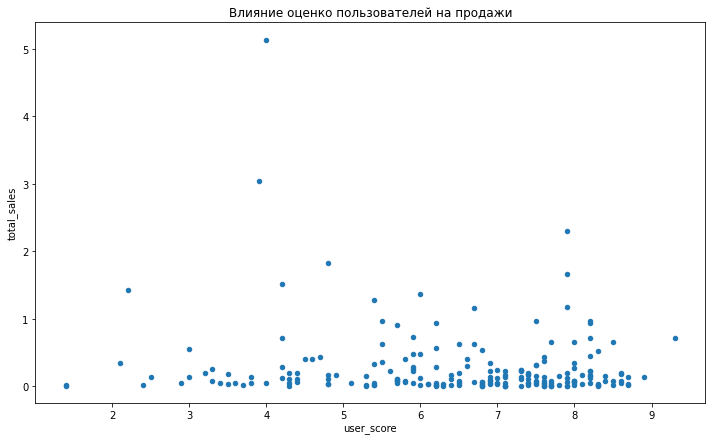

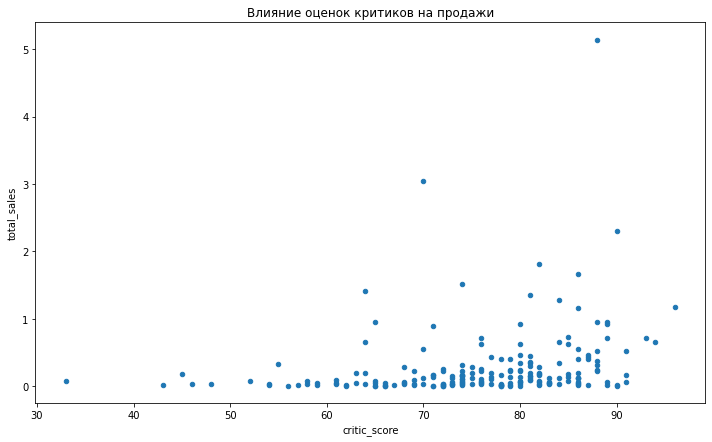

In [44]:
#Построим диаграмму рассеяния
pc_data.plot(x='user_score', y='total_sales', kind='scatter', figsize=(12,7))
plt.title('Влияние оценко пользователей на продажи');
pc_data.plot(x='critic_score', y='total_sales', kind='scatter', figsize=(12,7))
plt.title('Влияние оценок критиков на продажи');

**При рассмотрении оставшихся топовых платформ можно заметить, что только у WiiU появляется слабое влияние пользователей на продажи. Наверно это связанно с "возрастом" консоли. У остальных платформ влиение критиков слабо коррелирует**

#### Посмотрим на распределение игр по жанрам

In [45]:
# Комментарий ревьюера
temp1, temp2 = data_promising_platforms.total_sales.sum(), data.total_sales.sum()
temp1, temp2, round((temp2-temp1)/temp2*100, 2)

(406.46997, 8814.37, 95.39)

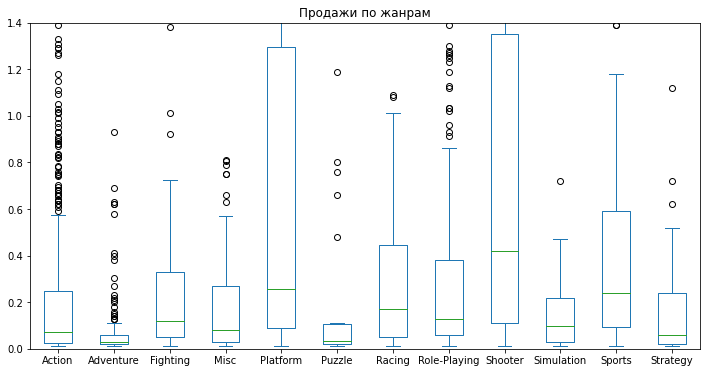

In [46]:
# соберем табличку и построим круговую диаграмму
# data.pivot_table(index = 'genre', 
#                  values = 'total_sales', 
#                  aggfunc = 'median').plot(y= 'total_sales', kind='box', figsize=(12,12));


actual_data.pivot_table(index = 'name', 
                         columns = 'genre', 
                         values = 'total_sales', 
                         aggfunc = 'median').plot(kind='box', figsize=(12,6), ylim=(0,1.4), title='Продажи по жанрам');

**Как видим жанр Shooter медианно занимает лидирующую позицию. Но при этом большое колличество выстреливающих игр находится в Action жанрах**

**Подытожим:
<br>Игровая индустрия начинает расти с 90х годов. Слегка запнувшись об 2012, но снова начинает расти
<br>Популярными платформами становятся PC, PS, Nintendo и XBox не зависимо от версии.
<br>Примерно раз в 5 лет они обновляют свою линейку и там идет время жизни около 10 лет
<br>При анализе отношения оценки / продажи, можно было увидеть, что оценки критиков влияют больше чем оценки пользователей. Исключением стало WiiU. Выходит, что мнение специалистов в области играет роль в отличии от диванных знатаков
<br>Ну и вишенкой на торте стал жанр Shooter. Он стал выбором на общей выборке для пользователей**


### Составим портрет пользователя каждого региона

#### Рассмотрим количество игр проданных на разные платформы и составим топ-5

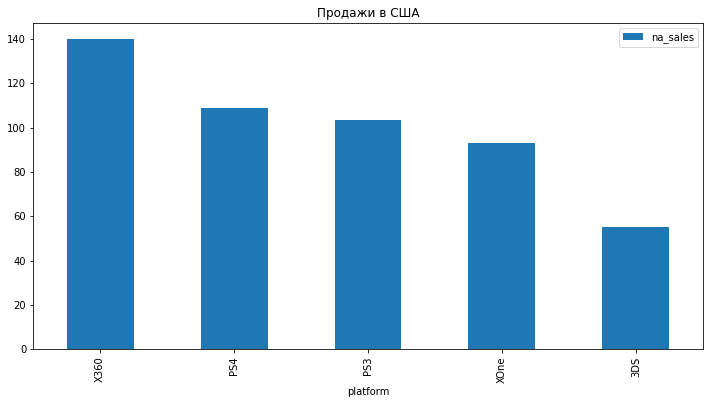

In [47]:
# собираем таблицу и смотрим на продажи в США
actual_data.pivot_table(index = 'platform', 
                                     values = 'na_sales', 
                                     aggfunc = 'sum').sort_values('na_sales',ascending=False)[:5].plot(kind = 'bar', 
                                                                                                       figsize=(12,6), 
                                                                                                       title='Продажи в США');

**Как видим в США чаще всего используют xbox. Поддерживают отечественное производство
<br>Но и не отстает PlayStation с их эксклюзивами. 
<br>Но и если оценить все столбцы, можно понять, что на Япоские консоли в сумме игр продают больше**

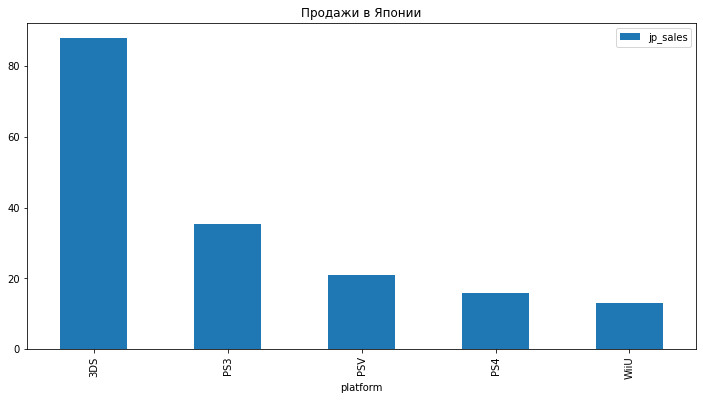

In [48]:
# собираем таблицу и смотрим на продажи в Японии
actual_data.pivot_table(index = 'platform', 
                                     values = 'jp_sales', 
                                     aggfunc = 'sum').sort_values('jp_sales',ascending=False)[:5].plot(kind = 'bar', 
                                                                                                       figsize=(12,6), 
                                                                                                       title='Продажи в Японии');

**В Японии как видим преобладает Nintendo DS. У них карманные каджеты в приоритете.
<br>Да и в целом преобладает Японский производитель, топ-5 только Nintendo и Sony**

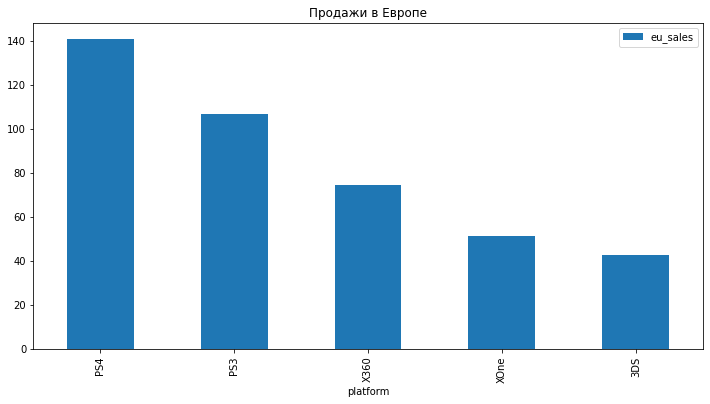

In [49]:
# собираем таблицу и смотрим на продажи в Европе
actual_data.pivot_table(index = 'platform', 
                                     values = 'eu_sales', 
                                     aggfunc = 'sum').sort_values('eu_sales',ascending=False)[:5].plot(kind = 'bar', 
                                                                                                       figsize=(12,6), 
                                                                                                       title='Продажи в Европе');

**В Европе лидирует PlayStation. Про xbox никто не забыл, они на 3 месте.
<br>Все-таки японское качество люди выбирают чаще**

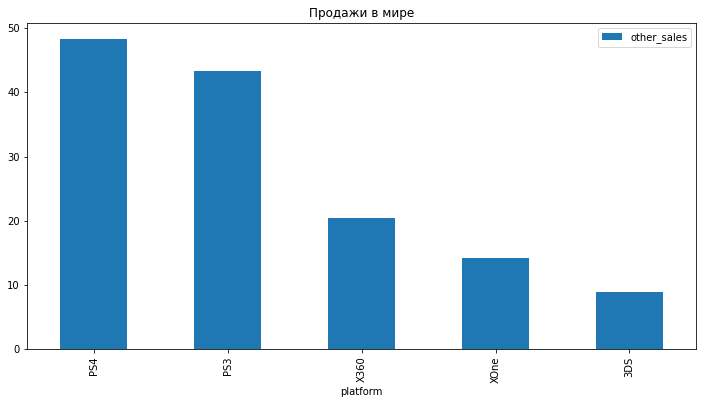

In [50]:
# собираем таблицу и смотрим на продажи в мире
actual_data.pivot_table(index = 'platform', 
                                     values = 'other_sales', 
                                     aggfunc = 'sum').sort_values('other_sales',ascending=False)[:5].plot(kind = 'bar', 
                                                                                                       figsize=(12,6), 
                                                                                                       title='Продажи в мире');

**Весь остальной мир также предпочитает PlayStation. В целом картина как в Европе**

#### Теперь рассмотри жанры по регионам и так же составим топ-5

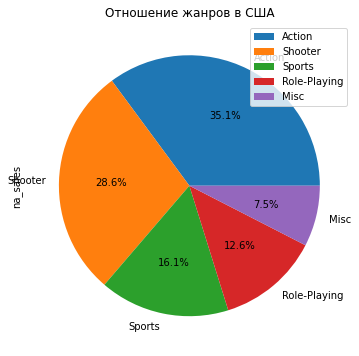

In [51]:
# собираем таблицу и смотрим на жанры в США
actual_data.pivot_table(index = 'genre', 
                 values = 'na_sales', 
                 aggfunc = 'sum').sort_values('na_sales',ascending=False)[:5].plot(y='na_sales',
                                                                                   kind = 'pie', 
                                                                                   figsize=(12,6),
                                                                                   autopct='%0.1f%%', 
                                                                                   title='Отношение жанров в США');

**Как видим, в США играют в Action игры и немного отстают "стрелялки"**

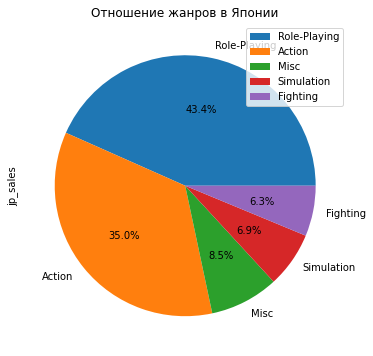

In [52]:
# собираем таблицу и смотрим на жанры в Японии
actual_data.pivot_table(index = 'genre', 
                 values = 'jp_sales', 
                 aggfunc = 'sum').sort_values('jp_sales',ascending=False)[:5].plot(y='jp_sales',
                                                                                   kind = 'pie', 
                                                                                   figsize=(12,6),
                                                                                   autopct='%0.1f%%', 
                                                                                   title='Отношение жанров в Японии');

**В Японии же предпочитают играть в РПГ, а лидирующие во всем мире Action игры только на втором месте**

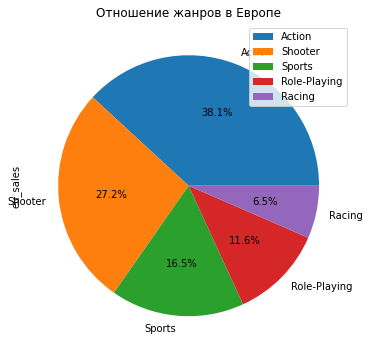

In [53]:
# собираем таблицу и смотрим на жанры в Европе
actual_data.pivot_table(index = 'genre', 
                 values = 'eu_sales', 
                 aggfunc = 'sum').sort_values('eu_sales',ascending=False)[:5].plot(y='eu_sales',
                                                                                   kind = 'pie', 
                                                                                   figsize=(12,6),
                                                                                   autopct='%0.1f%%', 
                                                                                   title='Отношение жанров в Европе');

**Европа не остает от мира и играет в Action**

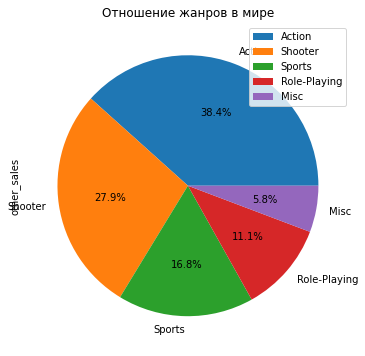

In [54]:
# собираем таблицу и смотрим на жанры в мире
actual_data.pivot_table(index = 'genre', 
                 values = 'other_sales', 
                 aggfunc = 'sum').sort_values('other_sales',ascending=False)[:5].plot(y='other_sales',
                                                                                   kind = 'pie', 
                                                                                   figsize=(12,6),
                                                                                   autopct='%0.1f%%', 
                                                                                   title='Отношение жанров в мире');

**Во всех остальных угалках так же преобладает Action**

#### Влияние рейтинга ESRB на продажи в отдельном регионе

In [55]:
# создадим заглушку
actual_data['rating'] = actual_data.loc[:,'rating'].fillna('WR')
actual_data['rating'].unique()

array(['M', 'WR', 'E', 'E10+', 'T'], dtype=object)

In [56]:
# соберем таблицу возрастных рейтингов
esrb = actual_data.pivot_table(index = 'rating', 
                               values = ['eu_sales','jp_sales','na_sales', 'other_sales'], 
                               aggfunc = 'sum')

In [57]:
esrb

,eu_sales,jp_sales,na_sales,other_sales
rating,,,,
E,113.029999,28.330000,114.370003,31.440001
E10+,55.369999,8.190000,75.699997,16.230000
M,193.960007,21.200001,231.569992,63.380001
T,52.959999,26.020000,66.019997,17.940001
WR,91.500000,108.839996,103.309998,27.170000


In [58]:
# Комментарий ревьюера
temp = data.copy()
print(temp.rating.isna().sum(), temp.rating.isna().sum()/len(temp))
temp.rating.value_counts()

6676 0.40598394551204087


E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
AO         1
RP         1
Name: rating, dtype: int64

### Проверяем гипотезы

In [59]:
# соберем только XBox One и PC с рейтингом больше 0
xone = actual_data[(actual_data['platform'] == 'XOne') &  (actual_data['user_score'] > 0)]['user_score']
pc = actual_data[(actual_data['platform'] == 'PC') &  (actual_data['user_score'] > 0)]['user_score']
print('Средний пользовательский рейтинг платформы Xbox One:', xone.mean())
print('Средний пользовательский рейтинг платформы PC', pc.mean())

Средний пользовательский рейтинг платформы Xbox One: 6.521428
Средний пользовательский рейтинг платформы PC 6.428641


**Для проверки гипотиз использую "Гипотезу о равенстве средних двух генеральных совокупностей"
<br>Поскольку нужно сравнивать средние двух генеральных совокупностей между собой**

**H0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые**
<br>
**<br>H1: Средние пользовательские рейтинги платформ Xbox One и PC разные**

In [60]:
#проверяем первую гипотезу
alpha = 0.05

results = st.ttest_ind(xone, pc, equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5489560454239967
Не получилось отвергнуть нулевую гипотезу


**Гипотеза не подтвердилась. Средние пользовательские рейтинги платформ Xbox One и PC разные**

In [61]:
# соберем только action и sports с рейтингом больше 0
action = actual_data[(actual_data['genre'] == 'Action') &  (actual_data['user_score'] > 0)]['user_score']
sports = actual_data[(actual_data['genre'] == 'Sports') &  (actual_data['user_score'] > 0)]['user_score']
print('Средний пользовательский рейтинг жанра Action:', action.mean())
print('Средний пользовательский рейтинг жанра Sports', sports.mean())

Средний пользовательский рейтинг жанра Action: 6.825048
Средний пользовательский рейтинг жанра Sports 5.455897


**H0: Средние пользовательские рейтинги жанров Action и Sports одинаковые**
<br>
<br>**H1: Средние пользовательские рейтинги жанров Action и Sports разные**

In [62]:
#проверяем вторую гипотезу

alpha = 0.05

results = st.ttest_ind(action, sports, equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.2428970996510126e-20
Отвергаем нулевую гипотезу


**Гипотеза подтвердилась. Средние пользовательские рейтинги жанров Action и Sports разные**

### Общие выводы

**Предварительно, до начала анализа, пришлось “причесать” данные. Понизил разрядность, регистр и изменил типы данных, для более удобного, а также быстро действующего дальнейшего продукта.
<br>Так же были обработаны пропуски, признаки, в которых слишком мало пропусков попросту удалил.
<br>Так же потребовалось добавить новый столбец, в частности суммарные продажи по всему миру.
<br>Перейдя к анализу, выяснилось:**
<br>**<pre>~Большинство платформ имеют жизненный цикл в районе 10 лет**
<br>**<pre>~Сами платформы стараются обновлять раз в 5 лет**
<br>**<pre>~Самые популярные платформы производят почти монополисты, это Sony, Microsoft и Nintendo**
<br>**<pre>~Так же выяснилось, что "слово" игровых критиков, не сильно, но влияет на продажи игр**
<br>**<pre>~Самыми продаваемыми жанрами по медиане стали Шуторы, но по выбросам можно понять, что очень много 'выстреливающих' игр в жанре Action**
<br>**Попробовав построить портрет геймера из разных регионов, тоже проявились некоторые подробности, а именно:**
<br>**<pre>~В США предпочитают играть в Action игры на Xbox**
<br>**<pre>~В Японии любят РПГ запускать на родных PlayStation**
<br>**<pre>~В Европе, как в США любят Action, но запускают на японский PlayStation**
<br>**<pre>~В остальном мире, как в Европе**
<br>**<pre>~Рейтинги игр влияют на сознания покупателей**
<br>**Так же были проверены гипотезы, что средние пользовательские рейтинги платформ Xbox One и PC разные, которая не подтвердилась. А также Средние пользовательские рейтинги жанров Action и Sports разные, которая в свою очередь подтвердилась.
<br>
<br>Подытожив я бы предолжил сделать рекламные компании по регионам:**
<br><pre>**~ Япония: RPG игры на PlayStaion4 без возрастного ограничения**
<br>**~ США: Action игры на XBoxOne с возрастным рейтингом M**
<br>**~ Для всего остального мира: Action игры на PlayStaion4 с возрастным рейтингом M**</pre>
